In [1]:
from drone_detector.utils import * 
from drone_detector.imports import *
import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
from src.tree_functions import *
from tqdm.auto import tqdm
tqdm.pandas()

# Stand-wise charasteristics from detection results

In [2]:
spk_stands = gpd.read_file('../../data/evo/MV_Hämeenlinna/MV_Hämeenlinna.gpkg', layer='stand')
spk_borders = gpd.read_file('../../data/evo/sudenpesankangas/spk_valid.geojson')
spk_results = gpd.read_file('../../results/evo/sudenpesankangas/merged/spk_full_new.gpkg', layer='predictions')

In [3]:
spk_stands = spk_stands.clip(spk_borders)

In [4]:
spk_results['tree_length'] = spk_results.geometry.progress_apply(get_len)
spk_results['diam'] = spk_results.geometry.progress_apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
spk_results['v_ddw'] = spk_results.geometry.progress_apply(cut_cone_volume)

  0%|          | 0/69165 [00:00<?, ?it/s]

  0%|          | 0/69165 [00:00<?, ?it/s]

  0%|          | 0/69165 [00:00<?, ?it/s]

Drop most obvious faulty groundwood detections (those with volume more than 5m³). These are for instance roads, gray rooftops etc.

In [5]:
spk_results.drop(spk_results[(spk_results.v_ddw > 5) & (spk_results.layer == 'groundwood')].index, inplace=True)

In [10]:
spk_results.layer.value_counts()

groundwood     55679
uprightwood    13359
Name: layer, dtype: int64

In [6]:
spk_stands.iloc[0].geometry.area, spk_stands.iloc[0].area

(6526.413476296049, 0.653)

In [7]:
spk_stands['n_dw'] = spk_stands.progress_apply(lambda row: len(spk_results[spk_results.geometry.within(row.geometry)]) 
                                                           / row.area, axis=1)
spk_stands['n_ddw'] = spk_stands.progress_apply(lambda row: len(spk_results[(spk_results.geometry.within(row.geometry)) 
                                                                             & (spk_results.layer=='groundwood')]) 
                                                           / row.area, axis=1)
spk_stands['n_udw'] = spk_stands.progress_apply(lambda row: len(spk_results[(spk_results.geometry.within(row.geometry)) 
                                                                             & (spk_results.layer=='uprightwood')]) 
                                                           / row.area, axis=1)
spk_stands['v_ddw'] = spk_stands.progress_apply(lambda row: spk_results[(spk_results.geometry.within(row.geometry)) 
                                                                        & (spk_results.layer=='groundwood')].v_ddw.sum() 
                                                           / row.area, axis=1)

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

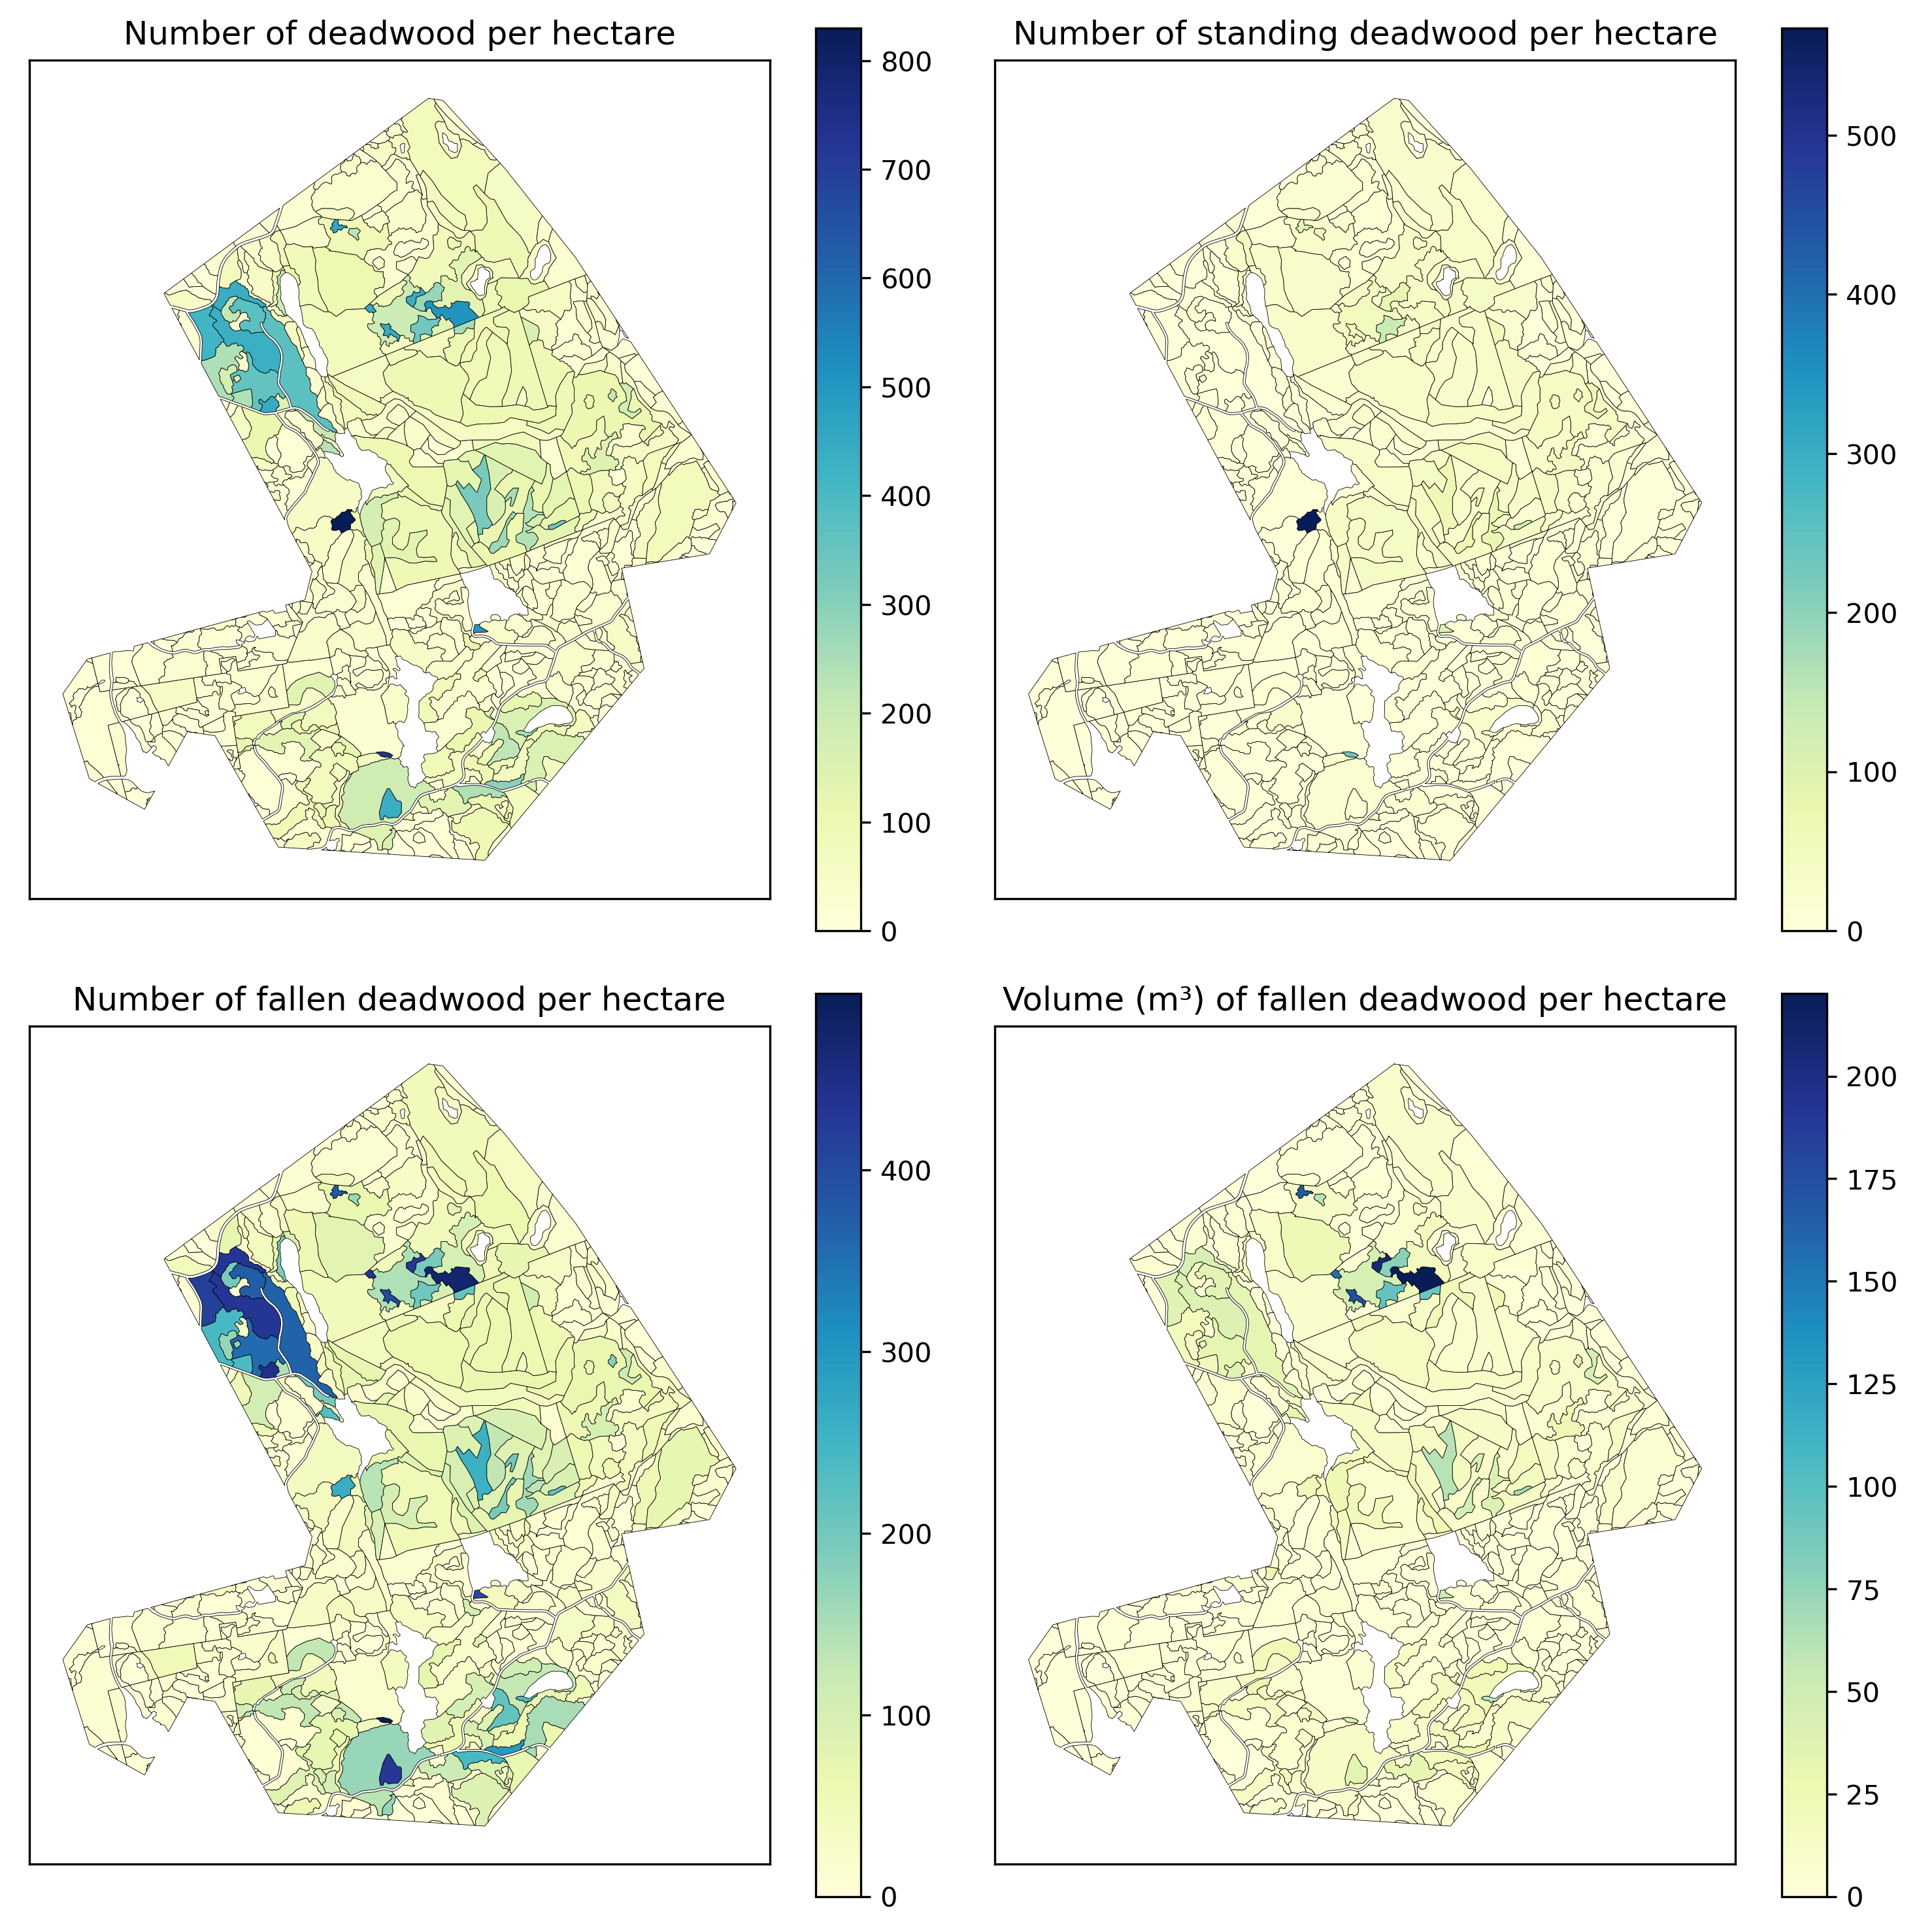

In [8]:
fig, ax = plt.subplots(2,2, dpi=300, figsize=(10,10))
spk_stands.plot(column='n_dw', legend=True, ax=ax[0,0], cmap='YlGnBu', edgecolor='black', linewidth=.2)
spk_stands.plot(column='n_udw', legend=True, ax=ax[0,1], cmap='YlGnBu', edgecolor='black', linewidth=.2)
spk_stands.plot(column='n_ddw', legend=True, ax=ax[1,0], cmap='YlGnBu', edgecolor='black', linewidth=.2)
spk_stands.plot(column='v_ddw', legend=True, ax=ax[1,1], cmap='YlGnBu', edgecolor='black', linewidth=.2)
ax[0,0].set_title('Number of deadwood per hectare')
ax[0,1].set_title('Number of standing deadwood per hectare')
ax[1,0].set_title('Number of fallen deadwood per hectare')
ax[1,1].set_title('Volume (m³) of fallen deadwood per hectare')
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.savefig('../../figures/stand_metrics_evo.jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
spk_stands.to_file('../../results/evo/sudenpesankangas/stand_results_new.geojson')